In [2]:
import pandas as pd

# Read the data
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Excl_Roil_Clean_NoNeg.csv')

df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Real Oil Prices
0,1992-03,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,...,4.065979,2.478218,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,13.601725
1,1992-04,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,...,4.069727,2.481568,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,14.512195
2,1992-06,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,...,4.072355,2.485740,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,15.981442
3,1992-07,8.999322,8.850346,4.036839,13.565973,12.027287,4.154825,4.283439,4.259519,4.418656,...,4.076435,2.484907,2.623218,2.436242,4.338597,11.060620,12.169643,6.666419,2.588035,15.501779
4,1992-11,8.996615,8.847863,4.050880,13.569488,12.049436,4.163143,4.292269,4.269875,4.429636,...,4.087739,2.491551,2.630449,2.441477,4.446174,11.042298,12.193706,6.705386,2.680611,14.313863


## Convert date to year, day so that it can be used in the model.
- Regression models (like random forest) can't use date as a feature. So we convert it to year and day.

In [3]:
# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Extract the year and the day of the year
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear


# Remove the date column
df.drop('date', axis=1, inplace=True)

#### 1. Splitting Data into Train and Test Sets

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split features and target variable
X = df.drop('Real Oil Prices', axis=1)
y = df['Real Oil Prices']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2. Grid Search for Algorithm Tuning

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Initialize the base model
base_rf = RandomForestRegressor(random_state=42)

# Grid search
#  By default, GridSearchCV uses the default scorer of the estimator (in the case of RandomForestRegressor, it's R^2).
grid_search = GridSearchCV(estimator=base_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters from Grid Search: {best_params}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters from Grid Search: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}


#### 3. Creating and Training the Random Forest Regressor and Predict

In [6]:
# Train RF with best parameters
# The ** operator lets us pass a dictionary as keyword arguments
# unpacks the dictionary(best_params) into individual parameters that RF expects
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions
predictions = best_rf.predict(X_test)

### Evaluation Metrics

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print("\nModel Evaluation after Grid Search:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"MAPE: {mape}")


Model Evaluation after Grid Search:
Mean Absolute Error: 0.798247877921501
Mean Squared Error: 0.9532872763417511
Root Mean Squared Error: 0.9763643153770785
R^2 Score: 0.9876462047894836
MAPE: 4.255941866973028


### Feature Importance

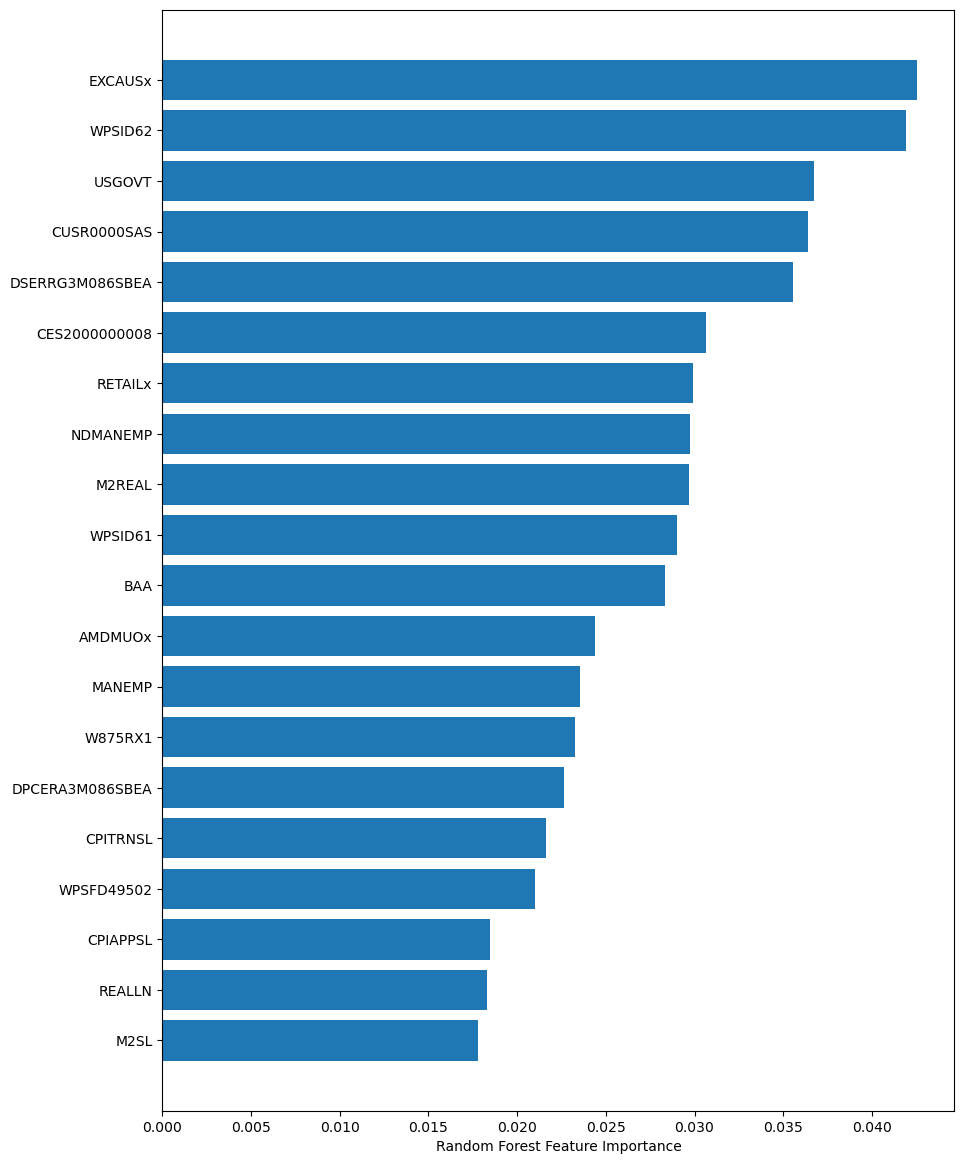

In [8]:
importances = best_rf.feature_importances_
features = X.columns

# Sorting feature importances
sorted_idx = importances.argsort()

# Selecting top 20
top_20_idx = sorted_idx[-20:]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))
plt.barh(range(20), importances[top_20_idx])
plt.yticks(range(20), features[top_20_idx], fontsize=10) 
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout(pad=2) 
plt.show()

### Learning Curve Attempt

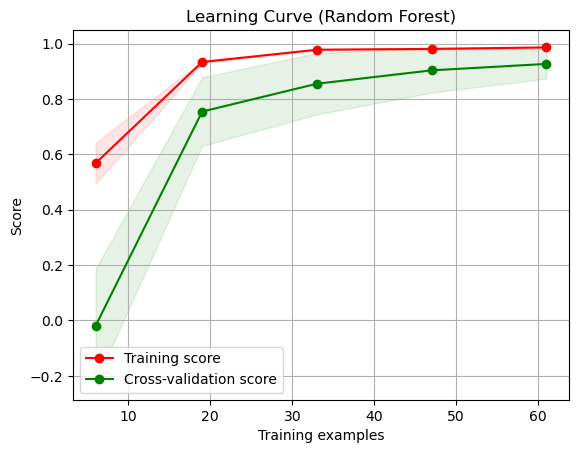

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train, y_train, cv=5)
plt.show()

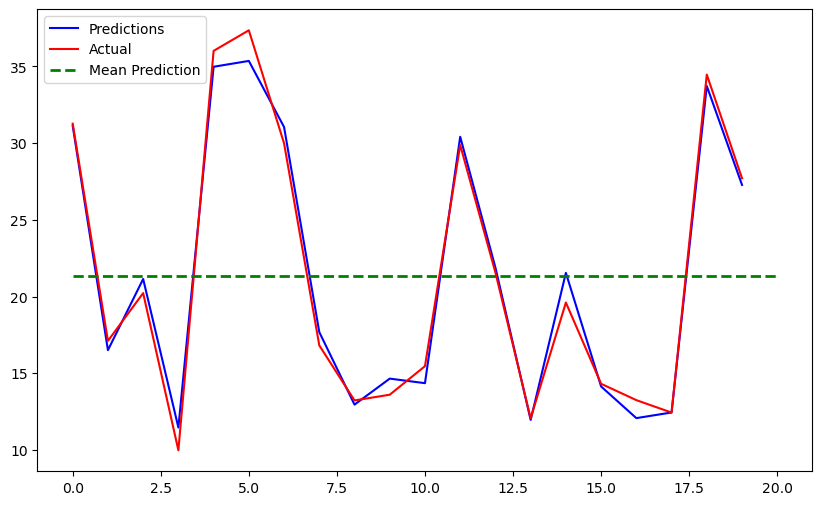

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions', color='blue')
plt.plot(y_test.values, label='Actual', color='red')

# Mean Prediction line
plt.plot([0, len(y_test)], [predictions.mean(), predictions.mean()], '--', lw=2, color='green', label='Mean Prediction')

plt.legend(loc='upper left')
plt.show()